<a href="https://colab.research.google.com/github/Shreeranga1/TimeSeries/blob/main/timeSeriesSession5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import numpy as np

In [34]:
df=pd.read_csv("https://raw.githubusercontent.com/Shreeranga1/TimeSeries/main/ice-creame_vs_heater.csv")

In [35]:
df['Time_stamp']=pd.date_range(start='1/1/2004',end='1/1/2019',freq='M')

In [36]:
df.set_index(df['Time_stamp'],inplace=True)

In [37]:
df.drop(columns=["Time_stamp","Month"],axis=1,inplace=True)

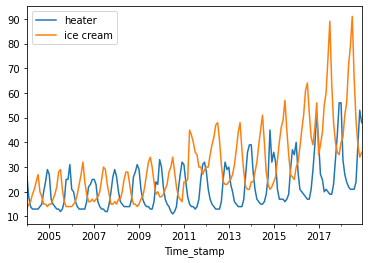

In [38]:
import matplotlib.pyplot as plt
df.plot()

Do cointegration test

In [39]:
from statsmodels.tsa.vector_ar.vecm       import coint_johansen
def cointegration_test(df, alpha=0.05): 
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 10): return str(val).ljust(length)
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
heater     ::  43.54     > 12.3212   =>   True
ice cream  ::  8.28      > 4.1296    =>   True


In [40]:
from datetime import datetime,timedelta
train_end=datetime(2016,1,31)
test_end=datetime(2018,12,31)

In [21]:
train_end

datetime.datetime(2016, 1, 31, 0, 0)

In [41]:
train             = df[:train_end]
test              = df[train_end + timedelta(days=1):test_end]

In [44]:
from statsmodels.tsa.stattools            import  adfuller
def adfuller_test(series,name=''):
    observations= series.values
    test_result = adfuller(observations)
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print('ADF Statistic: %f' % test_result[0])
    print('p-value: %f' % test_result[1])
    print('Critical Values:')
    for key, value in test_result[4].items():
            	print('\t%s: %.5f' % (key, value))

In [45]:
for name, column in train.iteritems():
    adfuller_test(column,name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "heater" 
    -----------------------------------------------
ADF Statistic: 0.696105
p-value: 0.989760
Critical Values:
	1%: -3.48050
	5%: -2.88353
	10%: -2.57850


    Augmented Dickey-Fuller Test on "ice cream" 
    -----------------------------------------------
ADF Statistic: -0.423977
p-value: 0.906018
Critical Values:
	1%: -3.48168
	5%: -2.88404
	10%: -2.57877




In [48]:
from statsmodels.tsa.api                  import  VAR
df_differenced = train.diff().dropna()
model = VAR(df_differenced)
for i in range(1,20):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)

Lag Order = 1
AIC :  5.674101884108013
Lag Order = 2
AIC :  5.605324816034614
Lag Order = 3
AIC :  5.383764766201941
Lag Order = 4
AIC :  4.977611970426087
Lag Order = 5
AIC :  4.653190859881615
Lag Order = 6
AIC :  4.485974280920685
Lag Order = 7
AIC :  4.424706078937111
Lag Order = 8
AIC :  4.263110083643431
Lag Order = 9
AIC :  4.1511758021474074
Lag Order = 10
AIC :  4.010108163298977
Lag Order = 11
AIC :  3.9365808068150416
Lag Order = 12
AIC :  3.950807454501641
Lag Order = 13
AIC :  4.013966612100768
Lag Order = 14
AIC :  4.055415101125694
Lag Order = 15
AIC :  4.101448135122013
Lag Order = 16
AIC :  4.1390081340740625
Lag Order = 17
AIC :  4.087473766217276
Lag Order = 18
AIC :  4.107678543728126
Lag Order = 19
AIC :  4.139107136631003


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [49]:
model_fitted = model.fit(11)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 16, Oct, 2021
Time:                     07:31:27
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    4.93625
Nobs:                     133.000    HQIC:                   4.34281
Log likelihood:          -593.220    FPE:                    51.6042
AIC:                      3.93658    Det(Omega_mle):         37.5093
--------------------------------------------------------------------
Results for equation heater
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.446533         0.212991            2.096           0.036
L1.heater            -0.862960         0.089059           -9.690           0.000
L1.ice cream         -0.015024         0.076617           -

In [50]:
forecast_input = df_differenced.values[-11:]
forecast_input

array([[-11.,   7.],
       [ -4.,   7.],
       [  0.,   6.],
       [  0.,   3.],
       [ -1.,   8.],
       [  1., -12.],
       [  2., -10.],
       [ 10.,  -8.],
       [  8.,  -1.],
       [ -2.,  -1.],
       [  5.,   5.]])

In [51]:
forecast=model_fitted.forecast(y=forecast_input,steps=len(test))
forecast=pd.DataFrame(forecast,index=df.index[-35:], columns=df.columns)

In [52]:
def invert_transformation(train, forecast):
    df_fc = forecast.copy()
    columns = train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

In [53]:
df_results = invert_transformation(train,forecast)

In [54]:
df_results.head()

,heater,ice cream,heater_forecast,ice cream_forecast
Time_stamp,,,,
2016-02-29,-9.504152,1.641074,30.495848,31.641074
2016-03-31,-8.689743,3.282810,21.806104,34.923884
2016-04-30,-4.989611,4.868854,16.816493,39.792738
2016-05-31,0.137790,5.264860,16.954284,45.057598
2016-06-30,-0.958333,6.315112,15.995950,51.372710
